## Assignment
Must make use of ratings, merge with another DF. Answer an interesting question about the Muppets!

## Question

**How long is the average film career before appearing in the muppets?**

**Does the Muppet Show make or break a film career?**

Criteria:
1. Guest star on the Muppet Show
2. Actor / actress
3. First film is >5 years prior
4. Last film is >5 years after

_"That's a high light in my career, going to England to film the Muppet show. Working with Jim Henson was great, he was a genius."_
Florence Henderson


## Data Wrangling

In [1]:
import numpy as np 
import pandas as pd
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def createCodebookTable(df):

    df_codebook = pd.DataFrame(index=df.columns, columns=["dtype","type","min","max","count","missing"])
    df_codebook["dtype"] = [str(df[x].dtype) for x in df.columns]
    df_codebook["type"] = [str(type(df[x][0])) for x in df.columns]
    
    df_codebook["min"] = df.min() 
    df_codebook["max"] = df.max() 
    df_codebook["count"] = df.count()
    df_codebook["missing"] = df.isnull().sum()
    
    return df_codebook

def getData(df):
    '''Function to create a dataframe with the timeDelta (t-5, t-4,...t+5) as the index and the average rating, num. of episodes and the nconst as columns
       Parameters: dataframe 
       Returns: dataframe
    '''
    data=[]
    for i in df['nconst'].unique():
        df2=df[df['nconst']==i]
        pivot=pd.pivot_table(df2,index='timeDelta', values=['tconst', 'averageRating','nconst'], 
                             aggfunc={'tconst':'count', 'averageRating':'mean','nconst':'first'})
        data.append(pivot)
    
    return(pd.concat(data))

def getTstats(df):
    '''Function to create a dataframe with the t-stat and p-value of a difference of mean before and after muppets for each nconst
       Parameters: dataframe 
       Returns: dataframe
    '''   
    
    unique_nconst=df['nconst'].unique()
    
    results=pd.DataFrame(columns=['tstat_average','pval_average','tstat_tconst','pval_tconst'],index=unique_nconst)
    
    for nconst in unique_nconst:
        
        df_filter=df[df['nconst']==nconst]
        
        after_muppet=df_filter.query('timeDelta>0')
        before_muppet=df_filter.query('timeDelta<0')
        
        results.loc[nconst,'tstat_average']=stats.ttest_ind(after_muppet['averageRating'],before_muppet['averageRating']).statistic
        results.loc[nconst,'pval_average']=stats.ttest_ind(after_muppet['averageRating'],before_muppet['averageRating']).pvalue
        
        
        results.loc[nconst,'tstat_tconst']=stats.ttest_ind(after_muppet['tconst'],before_muppet['tconst']).statistic
        results.loc[nconst,'pval_tconst']=stats.ttest_ind(after_muppet['tconst'],before_muppet['tconst']).pvalue
        
    
    return(results)

In [2]:
# find the title tag (tconst) for The Muppet Show, as a reference for searching all other .tsv files
show_name = 'The Muppet Show'
show_type = 'tvSeries'

with gzip.open('title.basics.tsv.gz') as file :
    titles_df = pd.read_csv(file, dtype= str, sep='\t') # set dtype to str so no wasted computing on guessing type
    mup_row = titles_df[ (titles_df['primaryTitle'] == show_name ) & (titles_df['titleType'] == show_type ) ]
    
# store title tag for later use
mup_tconst = list(mup_row['tconst'])[0]

# Get list of episodes for the Muppet Show
with gzip.open('title.episode.tsv.gz') as file :
    epi_df = pd.read_csv(file, dtype= str, sep='\t') # set dtype to str so no wasted computing on guessing type
    epi_df = epi_df[ epi_df[ "parentTconst" ] == mup_tconst ] # return new dataframe which only has muppet episodes
    
epi_info_df = titles_df[ titles_df['tconst'].isin(epi_df['tconst'])]

# Create a list of each guest star in Muppet Show... start with the nconst identifier
with gzip.open('title.principals.tsv.gz') as file :
    prin_df = pd.read_csv(file, dtype = str, sep = '\t')
    prin_df = prin_df[ prin_df['tconst'].isin(epi_df['tconst']) ] # filter for the titles in Muppet Show and for actors

# filter out only the principals who are in category of 'self'
nconst_df = prin_df[ prin_df['category'] == 'self']

# Subset the name.basics.tsv file to include only the guest stars!
with gzip.open('name.basics.tsv.gz') as file :
    guest_df = pd.read_csv(file, dtype = str, sep = '\t')
    guest_df = guest_df[ guest_df['nconst'].isin(nconst_df['nconst'])]

# remove any guest that is not an individual (e.g. a band)
guest_df = guest_df[ pd.to_numeric(guest_df['birthYear'], errors = 'coerce') > 0 ]

In [3]:
# need some way of matching nconst --> tconst --> year Aired... so that we have a year of Muppet Appearance for each guest

# create a series of nconsts, yearAired
guest2_df = guest_df.copy()
guest2_df = guest2_df.set_index("nconst")

for index, row in guest_df.iterrows():
    nconst = row['nconst']
    tconst = list(nconst_df[ nconst_df['nconst'] == nconst ]['tconst'])[0]
    year = list(epi_info_df[ epi_info_df['tconst'] == tconst ]['startYear'])[0]
    guest2_df.loc[nconst,'yearOnMShow'] = year #find some way of assigning startYear to our guestdf!

with gzip.open('title.principals.tsv.gz') as file :
    shows_df = pd.read_csv(file, dtype = str, sep = '\t')
    shows_df = shows_df[ shows_df['nconst'].isin(guest2_df.index) ] # filter for the titles for actors

In [4]:
# Copying to be safe!
shows2_df = shows_df.copy()
shows2_df = shows2_df.merge(guest2_df,left_on="nconst",right_index=True)
shows3_df = shows2_df.loc[:,["tconst","nconst","characters","primaryName","yearOnMShow"]]

with gzip.open('title.basics.tsv.gz') as file :
    titles_guests_df = pd.read_csv(file, dtype= str, sep='\t')
    titles_guests_df = titles_guests_df[ titles_guests_df['tconst'].isin(shows3_df['tconst']) ]
    
# Copying again to be safe!
shows4_df = shows3_df.copy()
shows4_df = shows4_df.merge(titles_guests_df, on = "tconst")
shows4_df = shows4_df.loc[:,["tconst","nconst","characters","primaryName","yearOnMShow","startYear"]]

# open tsv file and load into a dataframe
with gzip.open('title.ratings.tsv.gz') as ratings_file :
    ratings_df = pd.read_csv(ratings_file,sep='\t')
    ratings_df = ratings_df[ ratings_df['tconst'].isin(shows4_df['tconst']) ]
    
shows5_df = shows4_df.copy()
shows5_df = shows5_df.merge(ratings_df, on = "tconst")

# Some additional cleaning!
shows5_df['startYear'] = shows5_df['startYear'].map(lambda x: int(x)) 
shows5_df['yearOnMShow'] = shows5_df['yearOnMShow'].map(lambda x: int(x)) 
shows5_df['timeDelta'] = shows5_df['startYear'] - shows5_df['yearOnMShow']
display(shows5_df.head())

# The codebook
createCodebookTable(shows5_df)

,tconst,nconst,characters,primaryName,yearOnMShow,startYear,averageRating,numVotes,timeDelta
0,tt0005077,nm0000634,"[""Narrator 1951 UK Sound Version""]",Peter Sellers,1978,1915,6.1,1191,-63
1,tt0043734,nm0000634,"[""Groucho Marx"",""Giuseppe"",""Cedric""]",Peter Sellers,1978,1951,5.9,80,-27
2,tt0043734,nm0589711,\N,Spike Milligan,1979,1951,5.9,80,-28
3,tt0043913,nm0000634,"[""The Major"",""Arnold Fringe""]",Peter Sellers,1978,1951,5.6,97,-27
4,tt0043913,nm0589711,\N,Spike Milligan,1979,1951,5.6,97,-28


,dtype,type,min,max,count,missing
tconst,object,<class 'str'>,tt0005077,tt9090130,11886,0
nconst,object,<class 'str'>,nm0000037,nm2037903,11886,0
characters,object,<class 'str'>,"[""'Basil Fawlty'"",""Himself""]",\N,11886,0
primaryName,object,<class 'str'>,Alan Arkin,Zero Mostel,11886,0
yearOnMShow,int64,<class 'numpy.int64'>,1976,1981,11886,0
startYear,int64,<class 'numpy.int64'>,1915,2018,11886,0
averageRating,float64,<class 'numpy.float64'>,1,10,11886,0
numVotes,int64,<class 'numpy.int64'>,5,1079518,11886,0
timeDelta,int64,<class 'numpy.int64'>,-63,42,11886,0


## Data Analysis

In [5]:
# Selecting the relevant time for your analysis 
relevant_time = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
shows_all = shows5_df[shows5_df['timeDelta'].isin(relevant_time)]

display(shows_all.head())

,tconst,nconst,characters,primaryName,yearOnMShow,startYear,averageRating,numVotes,timeDelta
50,tt0069803,nm0000634,"[""Rouquet""]",Peter Sellers,1978,1973,6.0,329,-5
51,tt0069803,nm0002198,"[""Visconti""]",Charles Aznavour,1976,1973,6.0,329,-3
52,tt0070106,nm0000634,"[""Dick Scratcher""]",Peter Sellers,1978,1973,5.2,117,-5
54,tt0070488,nm0000634,"[""Sam""]",Peter Sellers,1978,1973,7.0,296,-5
55,tt0070855,nm0000634,"[""Général Latour & General Latour"",""Major Robi...",Peter Sellers,1978,1974,5.3,526,-4


In [6]:
shows_all.describe()
# Nothing particularly spectacular at this point

,yearOnMShow,startYear,averageRating,numVotes,timeDelta
count,3305.000000,3305.000000,3305.000000,3.305000e+03,3305.000000
mean,1978.206657,1977.434191,7.402481,2.474845e+03,-0.772466
std,1.609582,3.373175,1.106130,3.311117e+04,2.866527
min,1976.000000,1971.000000,1.600000,5.000000e+00,-5.000000
25%,1977.000000,1975.000000,6.800000,1.200000e+01,-3.000000
50%,1978.000000,1977.000000,7.500000,4.200000e+01,-1.000000
75%,1980.000000,1980.000000,8.100000,9.800000e+01,1.000000
max,1981.000000,1986.000000,10.000000,1.079518e+06,5.000000


In [7]:
# Creating sorts by groups to see any info that can be extracted from the tables
# Also using the shows all table kept crashing my jupiters so using this filtered dataframe for the plot

showscount_plot = pd.DataFrame(shows_all.groupby(['timeDelta'])['tconst'].nunique())
showsrating_plot = pd.DataFrame(shows_all.groupby(['timeDelta'])['averageRating'].mean())

showscount_plot = showscount_plot.reset_index()
showsrating_plot = showsrating_plot.reset_index()

display(showscount_plot)
display(showsrating_plot)
# It looks like both the means and average ratings were falling on average for all the guest stars - sad times!

,timeDelta,tconst
0,-5,358
1,-4,335
2,-3,371
3,-2,347
4,-1,350
5,0,414
6,1,297
7,2,265
8,3,180
9,4,173


,timeDelta,averageRating
0,-5,7.663462
1,-4,7.580826
2,-3,7.690212
3,-2,7.540678
4,-1,7.430447
5,0,7.460465
6,1,7.374917
7,2,7.112000
8,3,6.848913
9,4,6.919780


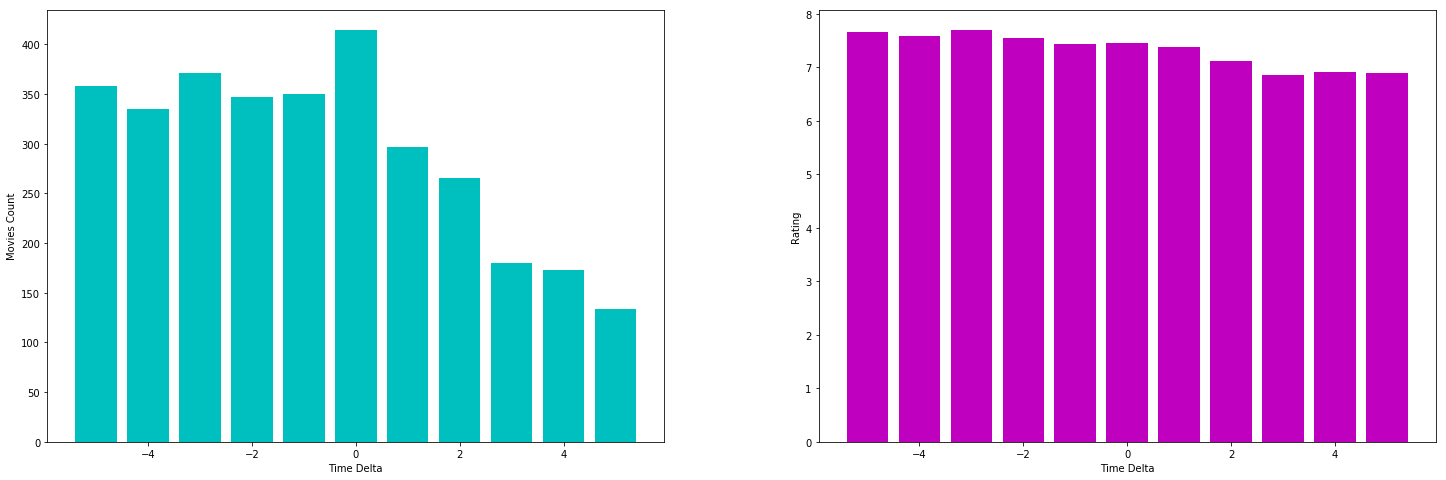

In [8]:
# A visualisation to drive the point home!

plt.subplot(131)
plt.bar(showscount_plot.timeDelta, showscount_plot.tconst, color='c')
plt.xlabel('Time Delta')
plt.ylabel('Movies Count')

plt.subplot(132)
plt.bar(showsrating_plot.timeDelta, showsrating_plot.averageRating,color='m')
plt.xlabel('Time Delta')
plt.ylabel('Rating')
plt.subplots_adjust(top=5, bottom=3.5, left=0, right=5, hspace=2.5, wspace=0.25)

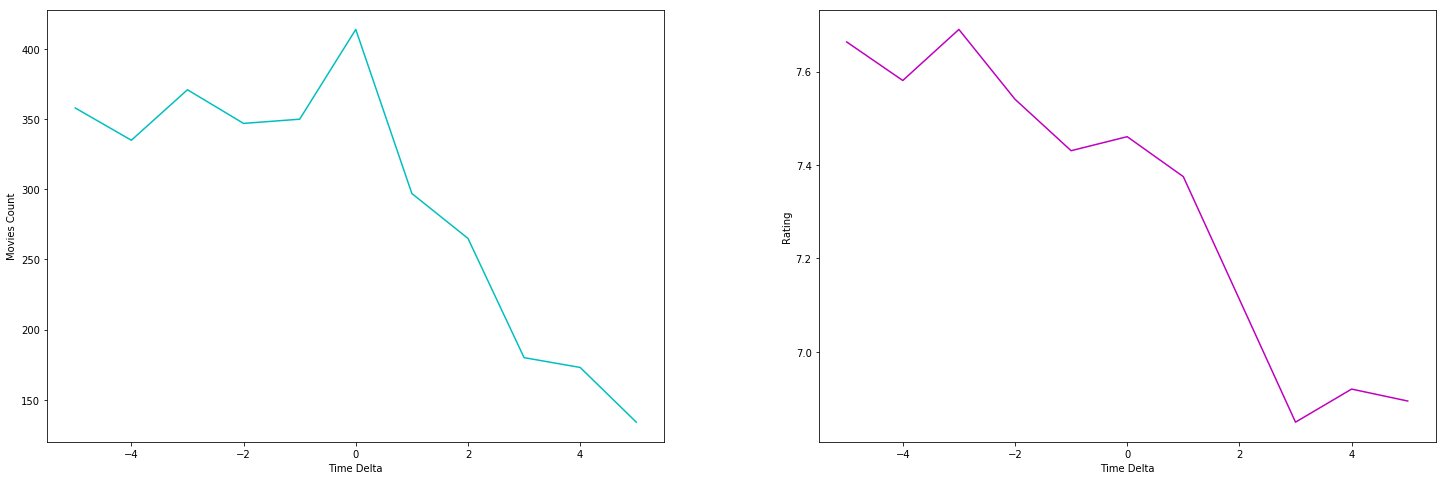

In [9]:
# Another visualisation to drive the point home! From the above chart, it could be surmised that the year the stars
# appeared on the show was their most popular year, after which they went into decline. These are sum totals though.

plt.subplot(131)
plt.plot(showscount_plot.timeDelta, showscount_plot.tconst, color='c')
plt.xlabel('Time Delta')
plt.ylabel('Movies Count')

plt.subplot(132)
plt.plot(showsrating_plot.timeDelta, showsrating_plot.averageRating, color='m')
plt.xlabel('Time Delta')
plt.ylabel('Rating')
plt.subplots_adjust(top=5, bottom=3.5, left=0, right=5, hspace=2.5, wspace=0.25)

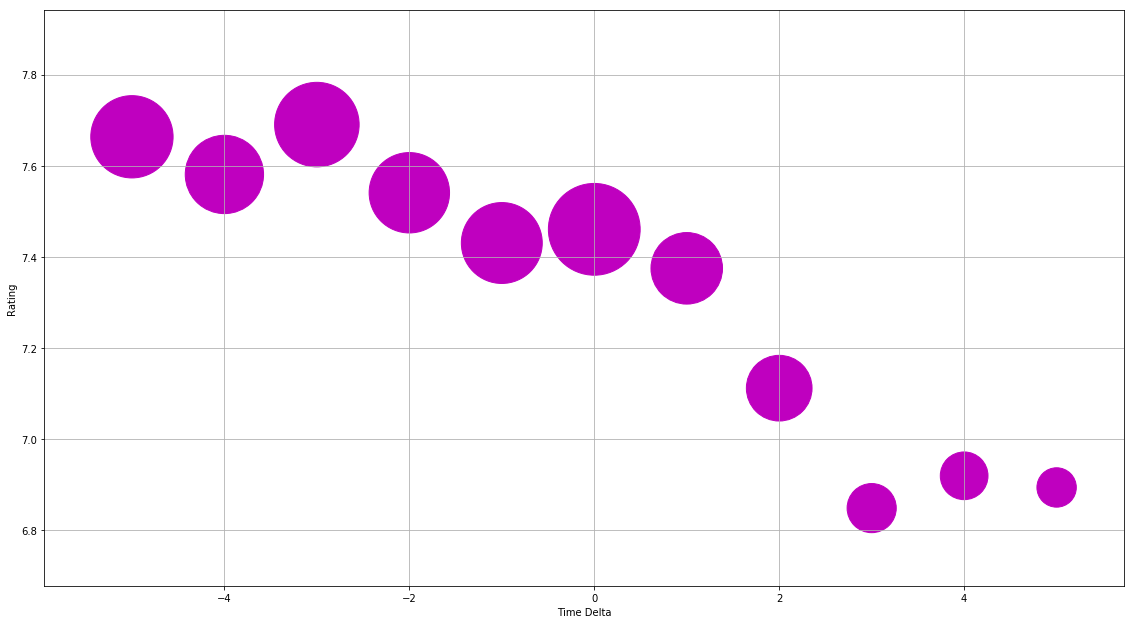

In [10]:
# Now combining the average ratings and number of appearances over time. 
# Appearances are represented by the size of the plot

plt.subplot(132)
plt.scatter(x = showsrating_plot.timeDelta, y = showsrating_plot.averageRating, s = (showscount_plot.tconst**1.5), color='m')
plt.xlabel('Time Delta')
plt.ylabel('Rating')
plt.grid(True)
plt.subplots_adjust(top=5, bottom=3, left=0, right=10, hspace=5, wspace=0.5)

plt.show()

In [11]:
# # Some other questions potentially worth answering:
# Who suffered the most from MuppetGate? Are they actors/actresses that have lost their careers?
# How do the averages differ for the guest stars? So far all our analysis has been on the sums
# Any other interesting questions?

In [21]:
flo_shows = shows_all[shows_all['primaryName'] == 'Florence Henderson']
flo_shows = flo_shows.sort_values(by = 'timeDelta')
display(flo_shows.head())

,tconst,nconst,characters,primaryName,yearOnMShow,startYear,averageRating,numVotes,timeDelta
5794,tt0531125,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1971,6.6,66,-5
5764,tt0531095,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1971,7.5,96,-5
5810,tt0531141,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1971,7.9,117,-5
5761,tt0531092,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1971,7.7,94,-5
5759,tt0531090,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1971,8.0,105,-5


In [42]:
# display(flo_shows.groupby(['timeDelta'])['tconst'].nunique())

flocount_plot = pd.DataFrame(flo_shows.groupby(['timeDelta'])['tconst'].nunique())
florating_plot = pd.DataFrame(flo_shows.groupby(['timeDelta'])['averageRating'].mean())

flocount_plot = flocount_plot.reset_index()
florating_plot = florating_plot.reset_index()

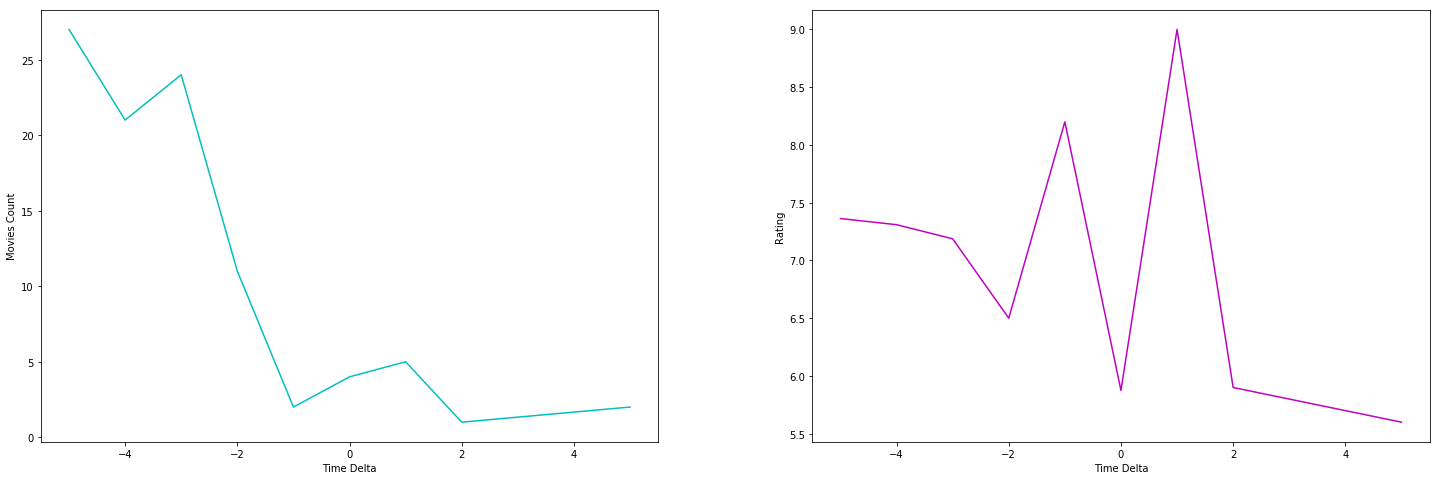

In [43]:
plt.subplot(131)
plt.plot(flocount_plot.timeDelta, flocount_plot.tconst, color='c')
plt.xlabel('Time Delta')
plt.ylabel('Movies Count')

plt.subplot(132)
plt.plot(florating_plot.timeDelta, florating_plot.averageRating, color='m')
plt.xlabel('Time Delta')
plt.ylabel('Rating')
plt.subplots_adjust(top=5, bottom=3.5, left=0, right=5, hspace=2.5, wspace=0.25)


In [44]:
display(florating_plot)

,timeDelta,averageRating
0,-5,7.362963
1,-4,7.309524
2,-3,7.187500
3,-2,6.500000
4,-1,8.200000
5,0,5.875000
6,1,9.000000
7,2,5.900000
8,5,5.600000


In [46]:
display(flo_shows[flo_shows['timeDelta'] == 1])


,tconst,nconst,characters,primaryName,yearOnMShow,startYear,averageRating,numVotes,timeDelta
5735,tt0531066,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1977,9.3,6,1
5734,tt0531064,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1977,9.2,5,1
5853,tt0727573,nm0001341,"[""Herself""]",Florence Henderson,1976,1977,8.8,5,1
5733,tt0531063,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1977,9.2,5,1
5732,tt0531059,nm0001341,"[""Carol Brady""]",Florence Henderson,1976,1977,8.5,6,1
